# Homework 5

## Analysis of Shakespeare's Plays  

<img src="Shakespeare.png" align="left">

##### By:  Umair Cheema, Athar Pasha

In [1]:
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

## Q1) Data Preparation

** i) Read data from the website and create a dataframe **

In [2]:
#Prepare Data Structures
base_url = 'http://shakespeare.mit.edu/'
html_filename_suffix = '/full.html'
#Create Arrays of Tragedies, Comedies and Historic writings (As retrieved from the links in URL address bar for plays)
comedies = ['allswell','asyoulikeit','comedy_errors','cymbeline','lll','measure','merry_wives', \
            'merchant','midsummer','much_ado','pericles','taming_shrew','troilus_cressida', \
            'twelfth_night','two_gentlemen','winters_tale','tempest']
historic = ['1henryiv','2henryiv','henryv','1henryvi','2henryvi','3henryvi','henryviii', \
             'john','richardii','richardiii']
tragedies = ['cleopatra','coriolanus','hamlet','julius_caesar','lear','macbeth','othello',\
           'romeo_juliet','timon','titus']

#Create a dictionary with genre as key
dict_shakespeare_plays_text = {'comedy':comedies,'historic':historic,'tragedy':tragedies}

In [3]:
#Function to return a dataframe with text from a single play
def get_play_text(genre, name):
    """
    Description : Returns text of a play as a dataframe
    Arguments:
            genre: String to identify genre of the play (tragedy, comedy, historic etc)
            name: String with abbreviated name of the play
    Returns : 
            Dataframe with Columns as playname, character, speech
    """
    page_url = base_url + name + html_filename_suffix
    columns = ['Genre','Play','Character','Speech']
    df = pd.DataFrame(columns=columns)
    #Read the HTML page
    page = urlopen(page_url).read()
    #Use BeautifulSoup to parse html page
    soup = BeautifulSoup(page,"lxml")
    #Initialize index
    index = 0
    #Find utterances by each play character in sequence
    for character in soup.find_all('b'):
        soup = character.find_next('blockquote')
        speech = soup.get_text()
        df.loc[index] = [genre,name,character.get_text(),speech.strip()]
        index = index + 1
    return df
    

In [4]:
#Test if the get play text is reading the text correctly
df_macbeth = get_play_text('tragedy','macbeth')

In [5]:
df_macbeth.head()

,Genre,Play,Character,Speech
0,tragedy,macbeth,First Witch,"When shall we three meet again\nIn thunder, li..."
1,tragedy,macbeth,Second Witch,"When the hurlyburly's done,\nWhen the battle's..."
2,tragedy,macbeth,Third Witch,That will be ere the set of sun.
3,tragedy,macbeth,First Witch,Where the place?
4,tragedy,macbeth,Second Witch,Upon the heath.


In [6]:
#Read all of the data in a single dataframe
play_frames = []
for (genre,plays) in dict_shakespeare_plays_text.items():
    for play in plays:
        play_frames.append(get_play_text(genre,play))
        
#Create the big dataframe that contains everything
df = pd.concat(play_frames)    

In [7]:
df.head()

,Genre,Play,Character,Speech
0,comedy,allswell,COUNTESS,"In delivering my son from me, I bury a second ..."
1,comedy,allswell,BERTRAM,"And I in going, madam, weep o'er my father's d..."
2,comedy,allswell,LAFEU,"You shall find of the king a husband, madam; y..."
3,comedy,allswell,COUNTESS,What hope is there of his majesty's amendment?
4,comedy,allswell,LAFEU,"He hath abandoned his physicians, madam; under..."


In [8]:
df.tail()

,Genre,Play,Character,Speech
561,tragedy,titus,Young LUCIUS,"O grandsire, grandsire! even with all my heart..."
562,tragedy,titus,AEMILIUS,"You sad Andronici, have done with woes:\nGive ..."
563,tragedy,titus,LUCIUS,"Set him breast-deep in earth, and famish him;\..."
564,tragedy,titus,AARON,"O, why should wrath be mute, and fury dumb?\nI..."
565,tragedy,titus,LUCIUS,"Some loving friends convey the emperor hence,\..."


** ii) Save dataframe as a pickle file **

In [9]:
#Save the dataframe as pickle so that we do not have to make network calls
df.to_pickle('shakespeare.pkl')

In [10]:
#Load DataFrame from Pickle
df_shakespeare = pd.read_pickle('shakespeare.pkl')

In [11]:
df_shakespeare.head(1)

,Genre,Play,Character,Speech
0,comedy,allswell,COUNTESS,"In delivering my son from me, I bury a second ..."


**iii) Case Folding: Convert text to lowercase**

In [12]:
df_shakespeare.Speech = df_shakespeare.Speech.str.lower()
df_shakespeare.Character = df_shakespeare.Character.str.lower()

In [13]:
df_shakespeare.tail()

,Genre,Play,Character,Speech
561,tragedy,titus,young lucius,"o grandsire, grandsire! even with all my heart..."
562,tragedy,titus,aemilius,"you sad andronici, have done with woes:\ngive ..."
563,tragedy,titus,lucius,"set him breast-deep in earth, and famish him;\..."
564,tragedy,titus,aaron,"o, why should wrath be mute, and fury dumb?\ni..."
565,tragedy,titus,lucius,"some loving friends convey the emperor hence,\..."


** iv) Remove Punctuations and other unwanted characters **

In [14]:
#Function to remove punctuation and other unwanted characters
def remove_unwanted_characters(input_text):
    """
    Description: Removes unwanted characters from the text
    Arguments: 
            input_text : String with input text
    Returns :
            Text with unwanted characters removed
    """
    prog = re.compile('[\t\n\r\f\v\d\']', re.UNICODE)
    output = re.sub(prog, ' ', input_text)
    #Remove punctuations
    prog = re.compile('[!\"#$%&\'()*+\,-./:;<=>?@[\]^_`{|}~]', re.UNICODE)
    output = re.sub(prog, ' ', output)
    #Remove multiple spaces with a single space
    output = re.sub(' +',' ',output)
    return output
    

In [15]:
#Remove punctuations and unwanted characters
df_shakespeare.Speech=df_shakespeare.Speech.apply(remove_unwanted_characters)

In [16]:
df_shakespeare.tail()

,Genre,Play,Character,Speech
561,tragedy,titus,young lucius,o grandsire grandsire even with all my heart w...
562,tragedy,titus,aemilius,you sad andronici have done with woes give sen...
563,tragedy,titus,lucius,set him breast deep in earth and famish him th...
564,tragedy,titus,aaron,o why should wrath be mute and fury dumb i am ...
565,tragedy,titus,lucius,some loving friends convey the emperor hence a...


** v) Remove stop words **

In [17]:
#Function to remove stop words
from nltk.corpus import stopwords
def remove_stopwords(input_text):
    """
    Description : Removes stop words and words 
    Arguments:
            input_text: String with input text
        
    Returns :
            String with stop words removed
    """
    output_text=[]
    stopwords_ = stopwords.words('english')
    output_text = ' '.join([word for word in input_text.split() if word not in stopwords_])
    return output_text

In [18]:
#Remove stop words
# added the next 2 lines on 7/8/19. execute once only
# import nltk
# nltk.download('stopwords')
df_shakespeare.Speech=df_shakespeare.Speech.apply(remove_stopwords)

In [19]:
df_shakespeare.tail()

,Genre,Play,Character,Speech
561,tragedy,titus,young lucius,grandsire grandsire even heart would dead live...
562,tragedy,titus,aemilius,sad andronici done woes give sentence execrabl...
563,tragedy,titus,lucius,set breast deep earth famish let stand rave cr...
564,tragedy,titus,aaron,wrath mute fury dumb baby base prayers repent ...
565,tragedy,titus,lucius,loving friends convey emperor hence give buria...


** v) Stemming **
<br/>Stemming reduces a word to its most basic form. It is useful to reduce the dimensionality of the text data.

In [20]:
#Function to perform Stemming
from nltk.stem.porter import *

def stem_text(input_text):
    """
    Description : Stems the input text
    
    Arguments:
         input_text : A string with input text
    Returns :
          A stemmed version of the input text
    """
    stemmer = PorterStemmer()
    output_text = ' '.join([stemmer.stem(word) for word in input_text.split()])
    return output_text

In [21]:
#Reduce words to most basic stems 
df_shakespeare.Speech=df_shakespeare.Speech.apply(stem_text)

In [22]:
df_shakespeare.tail()

,Genre,Play,Character,Speech
561,tragedy,titus,young lucius,grandsir grandsir even heart would dead live l...
562,tragedy,titus,aemilius,sad andronici done woe give sentenc execr wret...
563,tragedy,titus,lucius,set breast deep earth famish let stand rave cr...
564,tragedy,titus,aaron,wrath mute furi dumb babi base prayer repent e...
565,tragedy,titus,lucius,love friend convey emperor henc give burial fa...


In [23]:
df_shakespeare.describe()

,Genre,Play,Character,Speech
count,30967,30967,30967,30967
unique,3,37,953,29030
top,comedy,othello,gloucester,
freq,14140,1182,480,397


There are 953 unique characters with 29086 utterances in 37 plays.

** Can we distinguish between plays or characters by the utterance lengths ?**

In [24]:
test = df_shakespeare.rank()

In [25]:
test.head()

,Genre,Play,Character,Speech
0,7070.5,4344.5,6551.0,5780.0
1,7070.5,4344.5,2667.5,9125.0
2,7070.5,4344.5,17121.5,22546.0
3,7070.5,4344.5,6551.0,11817.0
4,7070.5,4344.5,17121.5,10886.0


In [26]:
utterance_length = lambda x: len(x.split())
df_shakespeare_lengths = df_shakespeare.copy()
df_shakespeare_lengths['UtteranceLengths'] = df_shakespeare_lengths.Speech.apply(utterance_length)

In [27]:
df_shakespeare_lengths.tail()

,Genre,Play,Character,Speech,UtteranceLengths
561,tragedy,titus,young lucius,grandsir grandsir even heart would dead live l...,18
562,tragedy,titus,aemilius,sad andronici done woe give sentenc execr wret...,12
563,tragedy,titus,lucius,set breast deep earth famish let stand rave cr...,20
564,tragedy,titus,aaron,wrath mute furi dumb babi base prayer repent e...,24
565,tragedy,titus,lucius,love friend convey emperor henc give burial fa...,63


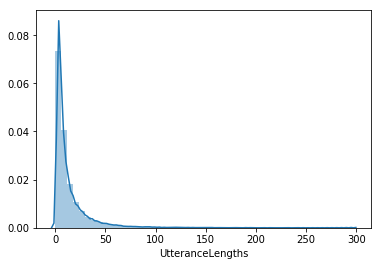

In [28]:
fig = sns.distplot(df_shakespeare_lengths.UtteranceLengths)

Looking at the distribution of the utterance lengths, it is clear that most of the sentences consist of 5 to 30 words and there are a handful of long sentences which probably are monologues.

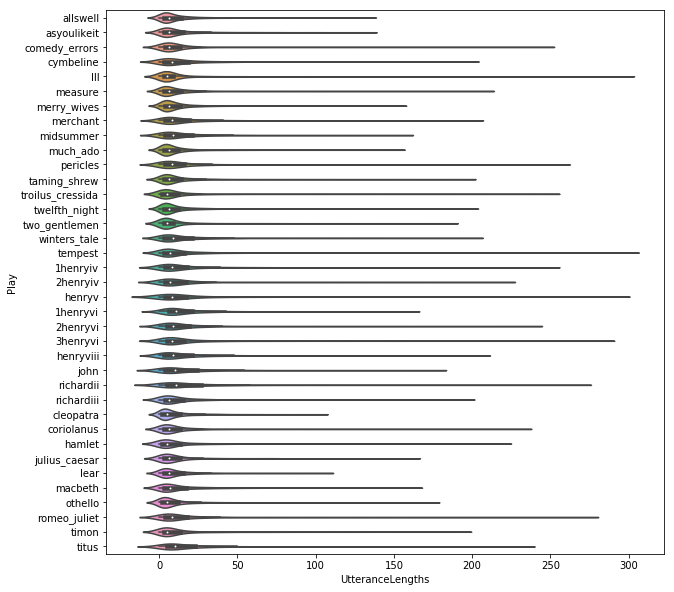

In [29]:
fig, ax =plt.subplots(figsize=(10,10))
sns.violinplot(x="UtteranceLengths", y="Play", data=df_shakespeare_lengths)


Looking at the violin plot, we can discern that comedies have longer utterance lengths than tragedies.

Can we distinguish between characters of a single play using distribution of utterance lengths?

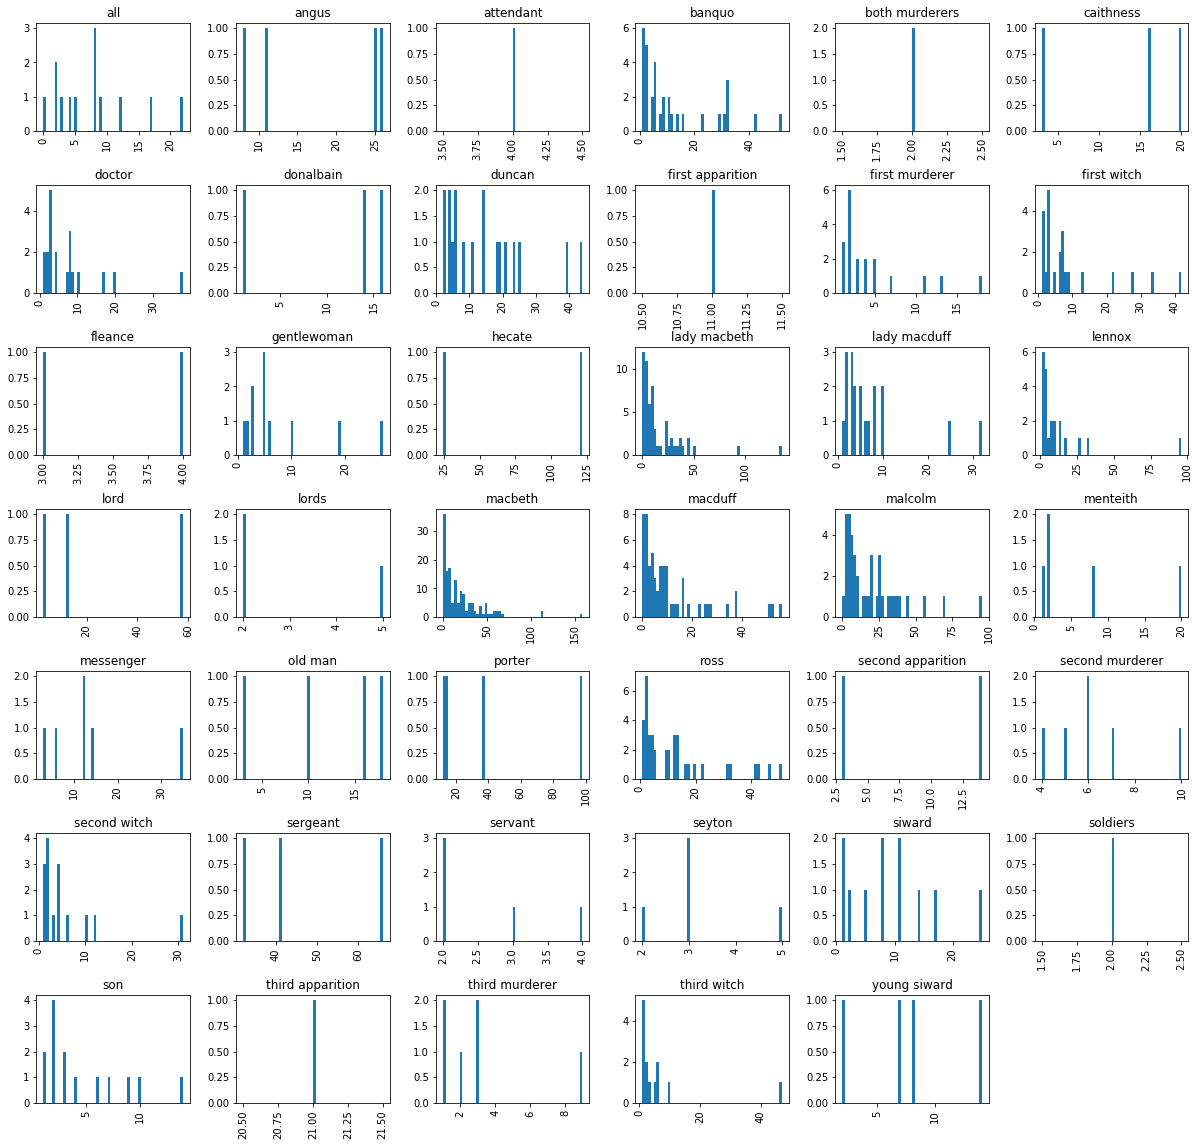

In [30]:
df_shakespeare_lengths[df_shakespeare_lengths['Play']=='macbeth'].hist(column='UtteranceLengths', by='Character',bins=50,figsize=(20,20));

This looks promising as different characters have different distribution of utterance lengths.

** vi) Grouping Utterances by characters **

In [31]:
df_shakespeare_lengths.head()

,Genre,Play,Character,Speech,UtteranceLengths
0,comedy,allswell,countess,deliv son buri second husband,5
1,comedy,allswell,bertram,go madam weep er father death anew must attend...,14
2,comedy,allswell,lafeu,shall find king husband madam sir father gener...,22
3,comedy,allswell,countess,hope majesti amend,3
4,comedy,allswell,lafeu,hath abandon physician madam whose practis hat...,16


In [32]:
#Create a copy of the original dataframe
df_pregroup=df_shakespeare_lengths.copy()


In [33]:
#Define utterance join lambda
utterance_join = lambda x:" ".join(x)
df_grouped=df_pregroup.groupby(['Play','Character'],as_index=False).agg({'Speech':utterance_join,'UtteranceLengths':np.sum})

In [34]:
df_grouped.tail()

,Play,Character,Speech,UtteranceLengths
1338,winters_tale,servant,pleas high post sent oracl come hour sinc cleo...,180
1339,winters_tale,shepard,ti said sir son marri shepherd daughter,7
1340,winters_tale,shepherd,would age sixteen three twenti youth would sle...,517
1341,winters_tale,third gentleman,true ever truth pregnant circumst hear swear s...,268
1342,winters_tale,time,pleas tri joy terror good bad make unfold erro...,127


**vii)Combine with Character Gender and Fool status**

In [35]:
#Load additional information about characters
df_characters = pd.read_csv('Shakespeare_characters.txt',sep='\t', encoding='latin1')
#Drop unwanted columns
del df_characters['#Lines']
del df_characters['Unnamed: 1']
df_characters.head()

,Speaker,Gender,Play,TopVillain,Fools
0,Bottom,Male,A Midsummer Night's Dream,NaN,fool
1,Theseus,Male,A Midsummer Night's Dream,NaN,NaN
2,Helena,Female,A Midsummer Night's Dream,NaN,NaN
3,Oberon,Male,A Midsummer Night's Dream,NaN,NaN
4,Puck,Male,A Midsummer Night's Dream,NaN,fool


In [36]:
#Clean the data for joining with grouped dataframe
df_characters.Speaker=df_characters.Speaker.str.lower()
df_characters.Play=df_characters.Play.str.lower()
df_characters.Gender=df_characters.Gender.str.lower()
fool2bool= lambda x: "Yes" if str(x).strip()=="fool" else "No"
villain2bool = lambda x: "Yes" if str(x).strip()=="yes" else "No"
df_characters.Fools = df_characters.Fools.apply(fool2bool)
df_characters.TopVillain = df_characters.TopVillain.apply(villain2bool)
print((df_characters.Play.unique()))
print(df_grouped.Play.unique())

["a midsummer night's dream" "all's well that ends well"
 'antony and cleopatra' 'as you like it' 'coriolanus' 'cymbeline' 'hamlet'
 'henry iv part 1' 'henry iv part 2' 'henry v' 'henry vi part 1'
 'henry vi part 2' 'henry vi part 3' 'henry viii' 'julius caesar'
 'king edward iii' 'king john' 'king lear' "love's labour's lost"
 'macbeth' 'measure for measure' 'much ado about nothing' 'othello'
 'pericles' 'richard ii' 'richard iii' 'romeo and juliet'
 'the comedy of errors' 'the merchant of venice'
 'the merry wives of windsor' 'the taming of the shrew' 'the tempest'
 'the two gentlemen of verona' 'the two noble kinsmen' "the winter's tale"
 'timon of athens' 'titus andronicus' 'troilus and cressida'
 'twelfth night']
['1henryiv' '1henryvi' '2henryiv' '2henryvi' '3henryvi' 'allswell'
 'asyoulikeit' 'cleopatra' 'comedy_errors' 'coriolanus' 'cymbeline'
 'hamlet' 'henryv' 'henryviii' 'john' 'julius_caesar' 'lear' 'lll'
 'macbeth' 'measure' 'merchant' 'merry_wives' 'midsummer' 'much_ado'
 

** This is interesting as we cannot merge the data frames until the plays have same names, we therefore need to map the play names **


In [37]:
#Change column name in the characters dataframe
df_characters.rename(columns={'Speaker':'Character'},inplace=True)

#Function to return full name of the play
def get_full_playname(brief_name):
    """
    Description : Returns full name given brief name
    Argument:
              brief_name: A String that contains brief name of the play
    Returns :
                full_name: A String with the full name
    """
    df_playnames_map = pd.read_csv('playmap.csv')
    index = 0
    for character in df_playnames_map.Brief:
        if(brief_name == character):
            return df_playnames_map.Full[index]
        else:
            index = index + 1
    return brief_name
    
#Change the Play names in the grouped data frame
df_grouped.Play = df_grouped.Play.apply(get_full_playname)


In [38]:
df_grouped.tail()

,Play,Character,Speech,UtteranceLengths
1338,the winter's tale,servant,pleas high post sent oracl come hour sinc cleo...,180
1339,the winter's tale,shepard,ti said sir son marri shepherd daughter,7
1340,the winter's tale,shepherd,would age sixteen three twenti youth would sle...,517
1341,the winter's tale,third gentleman,true ever truth pregnant circumst hear swear s...,268
1342,the winter's tale,time,pleas tri joy terror good bad make unfold erro...,127


In [39]:
#Merge the data frames based on play and character
df_combined = pd.merge(df_grouped,df_characters, how='left',on=['Play','Character'])
df_combined.head()

,Play,Character,Speech,UtteranceLengths,Gender,TopVillain,Fools
0,henry iv part 1,archbishop of york,hie good sir michael bear seal brief wing hast...,140,NaN,NaN,NaN
1,henry iv part 1,bardolph,case ye case ye vizard money king come hill ti...,98,male,No,No
2,henry iv part 1,carrier,fat butter,2,NaN,NaN,NaN
3,henry iv part 1,chamberlain,within hand quoth pick purs good morrow master...,77,male,No,No
4,henry iv part 1,earl of douglas,thou art king honour man potent breath upon gr...,191,NaN,NaN,NaN


**Drop the rows that do have NaNs so that we can do clustering based on Gender, Villain status and Fool status**

In [40]:
print(df_combined.size)
df_combined = df_combined.dropna()
print(df_combined.size)

9408
5999


Looking at the difference in records after dropping NAN, we can conclude that there is no significant loss in loosing records with missing values.

In [41]:
#Display the structure of the final dataset that is to be used for clustering.
df_combined.head()

,Play,Character,Speech,UtteranceLengths,Gender,TopVillain,Fools
1,henry iv part 1,bardolph,case ye case ye vizard money king come hill ti...,98,male,No,No
3,henry iv part 1,chamberlain,within hand quoth pick purs good morrow master...,77,male,No,No
6,henry iv part 1,falstaff,hal time day lad inde come near hal take purs ...,2844,male,No,Yes
7,henry iv part 1,first carrier,heigh ho four day hang charl wain new chimney ...,99,male,No,No
8,henry iv part 1,first traveller,come neighbour boy shall lead hors hill walk a...,12,male,No,No


**viii) Convert Text to Features using TF-IDF**

In [42]:

vectorizer = TfidfVectorizer(max_df=0.8,
                                 use_idf=True)
X = df_combined.Speech.values 
X = vectorizer.fit_transform(X)


In [43]:
X

<857x11751 sparse matrix of type '<class 'numpy.float64'>'
	with 154913 stored elements in Compressed Sparse Row format>

In [44]:
vocabulary = vectorizer.get_feature_names()
print(len(vocabulary))
print(X.shape)

11751
(857, 11751)


## Q2) Clustering

** i) Normalize the vectorized data before passing on to Clustering Algorithms **

In [45]:
#Normalize the vectorized data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
X = normalizer.fit_transform(X)

** ii) A generic function to prepare and compute metrics for clustering **

We have selected following metrics for clustering evaluation:
 <br/>**homogeneity :** Which is a bounded score from 0 to 1 indicating that each cluster contains only members of a single   class 
 <br/>**completeness :** A bounded score from 0 to 1 indicating that all members of a given class are asigned to the same cluster.
 <br/>**adjusted rand index:** A bounded score from -1 to 1, it measures the similarity of the cluster assignments

In [54]:
#Define a function that prepares clustering model, clusters vectorized data and computes metrics
def compute_clustering_metrics(clustering_alg_,X,labels):
    """
    Description : Given a clustering algorithm, number of clusters and actual labels
                  this function returns clustering metrics (homogeneity score, etc)
    Arguments:
                clustering_alg: A string that has clustering method name
                X : vectorized data
                labels: A  Pandas dataframe Series object
    Returns : 
              A tuple of tuple with homogeneity, completeness and adjusted rand scores
              and the cluster centroid objects              
    """
    number_of_clusters = len(labels.unique())
    clustering_alg = None
    centroids = None
    if (clustering_alg_ == 'k-means'):
        clustering_alg = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=10000,n_init=10)
        clustering_alg.fit(X)
        centroids = clustering_alg.cluster_centers_.argsort()[:, ::-1]
        clustering_alg_labels = pairwise_distances_argmin(X, (np.sort(clustering_alg.cluster_centers_,axis=0)))
    else:
        clustering_alg = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean',linkage='ward')
        clustering_alg.fit(X)
        clustering_alg_labels = clustering_alg.labels_
    
    homogeneity = metrics.homogeneity_score(labels, clustering_alg_labels)
    completeness = metrics.completeness_score(labels,clustering_alg_labels)
    adjusted_rand = metrics.adjusted_rand_score(labels,clustering_alg_labels)
    
    return (centroids,(homogeneity,completeness,adjusted_rand),number_of_clusters)
    

**ii) Conduct K-Means clustering (without optimization)**

In [56]:
#Conduct K-Means clustering with different number of clusters
# to check hypothesis
criteria = ['Play','Character','Gender','TopVillain','Fools']

for criterion in criteria:
    kmeans = compute_clustering_metrics('k-means',X,df_combined[criterion])
    kmeans_centroids = kmeans[0]
    kmeans_metrics = kmeans[1]
    n_clusters = kmeans[2]
    print(criterion)
    print('---------')
    print('Number of Clusters: %s' %n_clusters)
    print('Homogeneity Score: %s' % kmeans_metrics[0])
    print('Completeness Score: %s' %kmeans_metrics[1])
    print('Adjusted Rand Index: %s' %kmeans_metrics[2])
    print('\n')

Play
---------
Number of Clusters: 30
Homogeneity Score: 0.17063906059742376
Completeness Score: 0.18235123131373915
Adjusted Rand Index: 0.008605923008744366


Character
---------
Number of Clusters: 632
Homogeneity Score: 0.6763874650451489
Completeness Score: 0.9064892456573491
Adjusted Rand Index: 0.00988597578408102


Gender
---------
Number of Clusters: 2
Homogeneity Score: 0.042085646362510006
Completeness Score: 0.023847094680667164
Adjusted Rand Index: 0.08036032633293887


TopVillain
---------
Number of Clusters: 2
Homogeneity Score: 0.10160854691712656
Completeness Score: 0.00689558035489655
Adjusted Rand Index: 0.01363228999514355


Fools
---------
Number of Clusters: 2
Homogeneity Score: 0.1348842173734055
Completeness Score: 0.019867903271973724
Adjusted Rand Index: 0.03322183114672655




** First of all it is important to note that when number of clusters are large (>10) ARI is a better assessment metric than completeness and homogeneity. Now if we look at the scores above it is clear that Gender is not distinguishable by language but the language used by fools is different from non fool characters.Furthermore a better cluster separation is done for Plays as opposed to the Characters using ARI index ** 

In [ ]:
#Conduct K-Means Clustering using Genre as label for testing the accuracy
vectorizer_genre = TfidfVectorizer(max_df=0.8,
                                 use_idf=True)
X_genre = df_shakespeare_lengths.Speech.values
X_genre = vectorizer_genre.fit_transform(X_genre)

kmeans = compute_clustering_metrics('k-means',X_genre,df_shakespeare_lengths['Genre'])
kmeans_centroids = kmeans[0]
kmeans_metrics = kmeans[1]
n_clusters = kmeans[2]
print('Genre')
print('---------')
print('Number of Clusters: %s' %n_clusters)
print('Homogeneity Score: %s' % kmeans_metrics[0])
print('Completeness Score: %s' %kmeans_metrics[1])
print('Adjusted Rand Index: %s' %kmeans_metrics[2])
print('\n')

In [ ]:
X_genre

**iii) Conduct K-Means Clustering (With Optimization)**

In [ ]:
# We shall use Silhouette analysis to find optimal number of clusters
clusters = np.arange(2,50)
max_silhouette_score = 0
optimal_number_of_clusters = 2
for number_of_clusters in clusters:
    clusterer = KMeans(n_clusters=number_of_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #Compute average silhouette score
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    if(silhouette_avg>max_silhouette_score):
        max_silhouette_score = silhouette_avg
        optimal_number_of_clusters = number_of_clusters
print('Maximum Silhouette score is: ',max_silhouette_score)
print('Optimal number of clusters are: ',optimal_number_of_clusters)
    

In [ ]:
#A generic function to print terms closes to cluster center
def closest_terms(cluster, vectorizer,number_of_clusters):  
    ordered_centroids = cluster.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    all_terms = []
    for i in range(number_of_clusters):
        cluster_terms=[]
        for ind in ordered_centroids[i, :200]:
            cluster_terms.append(terms[ind])
        all_terms.append(cluster_terms)
    return all_terms   

In [ ]:
#Print top ten terms for every cluster
clusterer = KMeans(n_clusters=48, random_state=10)
clusterer.fit(X)
cterms = closest_terms(clusterer, vectorizer,48)

In [ ]:
#Print the first 20 terms to get an idea of separation
for terms in cterms:
    print(terms[:10])


**iv) Conduct Hierarchical clustering**

In [57]:
from sklearn.cluster import AgglomerativeClustering
#Conduct Hierarchical clustering with different number of clusters
criteria = ['Play','Character','Gender','TopVillain','Fools']


for criterion in criteria:
    aggl = compute_clustering_metrics('Agglomerative',X.toarray(),df_combined[criterion])
    aggl_metrics = aggl[1]
    print(criterion)
    print('---------')
    print('Homogeneity Score: %s' % aggl_metrics[0])
    print('Completeness Score: %s' %aggl_metrics[1])
    print('Adjusted Rand Index: %s' %aggl_metrics[2])
    print('\n')

Play
---------
Homogeneity Score: 0.38368341154748536
Completeness Score: 0.4732462546531268
Adjusted Rand Index: 0.08389515648354742


Character
---------
Homogeneity Score: 0.9297661487019443
Completeness Score: 0.9234251038051411
Adjusted Rand Index: 0.009023114622729134


Gender
---------
Homogeneity Score: 0.051151605545232896
Completeness Score: 0.03649293401343301
Adjusted Rand Index: 0.1403850394293181


TopVillain
---------
Homogeneity Score: 0.040619667858835584
Completeness Score: 0.0034707632355914157
Adjusted Rand Index: 0.016798517750239196


Fools
---------
Homogeneity Score: 0.04943110875821279
Completeness Score: 0.009397847845458456
Adjusted Rand Index: 0.04308603202913207




**Looking at the results confirm that the language used between Characters is significantly different and hence forms clusters with better scores.**

## Q3) Visualizations to interpret clusters

** i) Multidimensional Scaling **

In [58]:
#Following code is adapted from http://brandonrose.org/clustering
#Compute the distance matrix using cosine similarity
distance_matrix = 1 - cosine_similarity(X.A)
# Reduce the feature dimensions using MDS
mds_text = MDS(n_components=2, dissimilarity="precomputed", random_state=10)
mds_shakespeare = mds_text.fit_transform(distance_matrix)
xs, ys = mds_shakespeare[:, 0], mds_shakespeare[:, 1]


In [59]:
km = KMeans(n_clusters=4, random_state=10)
cluster_labels = km.fit(X)
clusters = km.labels_.tolist()
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}
#set up cluster names using a dict
cluster_names = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3'}

C:\Users\atharp\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\atharp\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\atharp\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\atharp\AppDat

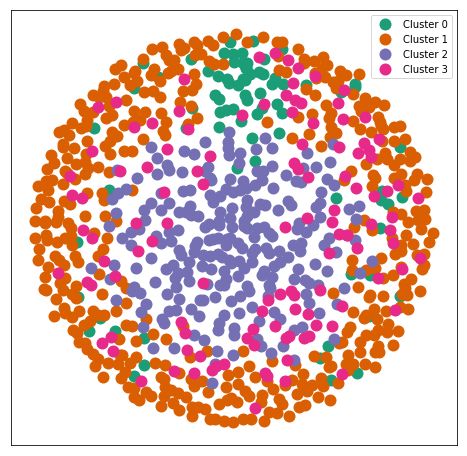

In [62]:
df_mds = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
#group by cluster
groups = df_mds.groupby('label')
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.margins(0.06)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
ax.legend(numpoints=1)  


for i in range(len(df_mds)): 
    ax.text(df_mds.ix[i]['x'], df_mds.ix[i]['y'],'', size=8)    
plt.show() 

In [68]:
##athar addition for test
groups

** ii) PCA **

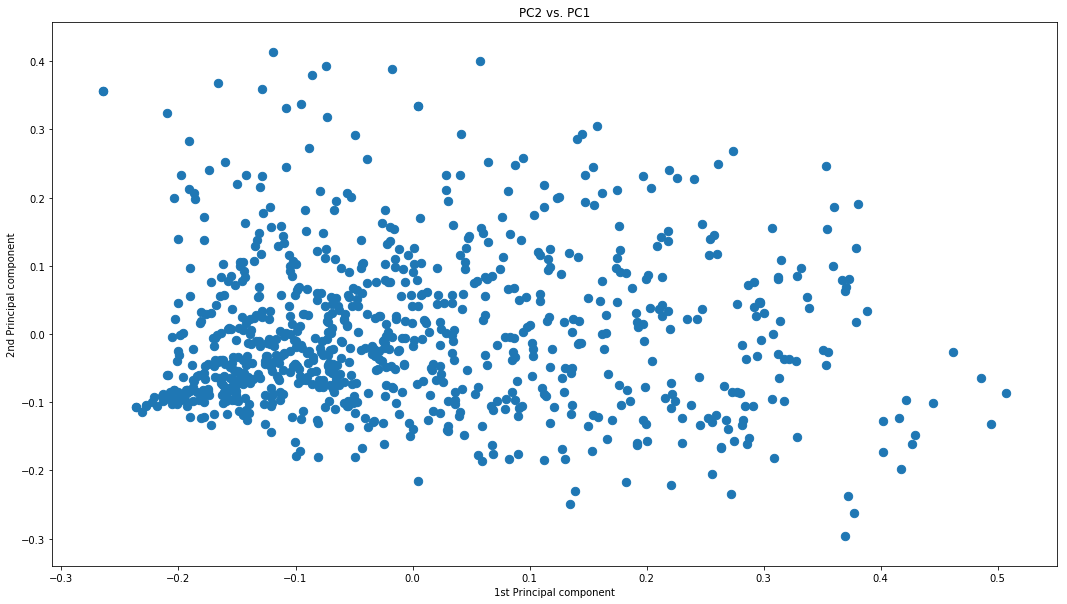

In [61]:
#Convert the feature matrix from sparse to dense format
X_dense = X.todense()
#Convert data into two dimensions
data2d = PCA(n_components=2).fit_transform(X_dense)
#Plot PCA 
fig, ax = plt.subplots(figsize=(18, 10))
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
ax.scatter(data2d[:,0], data2d[:,1],s = 70)

plt.show()

## Q4) Exploratory Data Points

We wish to find out if by using simple valence based sentiment analysis we can distinguish comedies from tragedies. We shall use the concept of Average Word Valence from the paper "Extracting Sentiment Networks from Shakespeare’s Plays" by Eric T. Nalisnick and Henry S. Baird for thus analysis. 


** i) Read AFFIN word list **

In [ ]:
afinn = dict(map(lambda kv: (kv[0],int(kv[1])),[line.split('\t') for line in open("afinn.txt")]))

** ii) Read Shakespeare Pickle file**

In [ ]:
#Load DataFrame from Pickle
df_shakespeare = pd.read_pickle('shakespeare.pkl')
df_shakespeare.head()

**iv) Compute Average Word Valence for every utterance **

In [ ]:
#Function to compute valence
def compute_utterance_valence(utterance):
    utterance = remove_unwanted_characters(utterance)
    utterance = remove_stopwords(utterance)
    utterance = utterance.lower()
    number_of_valence_words_found = 0
    aggregated_valence = 0
    for word in utterance.split():
        if word in afinn:
            number_of_valence_words_found = number_of_valence_words_found + 1
            aggregated_valence = aggregated_valence + afinn[word]
    if(number_of_valence_words_found == 0):
        average_valence = 0
    else:
        average_valence = aggregated_valence/number_of_valence_words_found
    return average_valence

In [ ]:
df_valence = df_shakespeare.copy()
df_valence['Valence'] = df_valence.Speech.apply(compute_utterance_valence)

In [ ]:
df_valence.head()

** v) Plot valence sums for different plays, characters and genre **

In [ ]:
df_g_genre= df_valence.groupby(['Genre'],as_index=False).agg({'Valence':np.sum})

In [ ]:
df_g_genre.plot('Genre','Valence',kind='bar')

In [ ]:
df_g_play = df_valence.groupby(['Play'],as_index=False).agg({'Valence':np.sum})
df_g_play.plot('Play','Valence',kind='barh',figsize=(15,15),fontsize=12, title='Cumulative Valence Score');
plt.axvline(0,color='green')

** Looking at the plots above we can conclude that valence words can distinguish between tragedies and comedies quite accurately. When cumulative valence is plotted for the plays, we find an anomaly in _Comedy of Errors_ which was found by the original authors of the paper as well. The anomaly is due to the fact that in _Comedy of Errors_ there are some dark features such as infidelity, theft and madness.**

**v) Cluster Cumulative Valences for Characters **

In [ ]:
df_g_characters = df_valence.groupby(['Play','Character'],as_index=False).agg({'Valence':np.sum})
X_v = df_g_characters.Valence.values.reshape(-1,1)

In [ ]:
#Find the optimal number of clusters using Silhouette Analysis
clusters = np.arange(2,10)
max_silhouette_score = 0
optimal_number_of_clusters = 2
for number_of_clusters in clusters:
    clusterer = KMeans(n_clusters=number_of_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_v)
    #Compute average silhouette score
    
    silhouette_avg = metrics.silhouette_score(X_v, cluster_labels)
    if(silhouette_avg>max_silhouette_score):
        max_silhouette_score = silhouette_avg
        optimal_number_of_clusters = number_of_clusters
print('Maximum Silhouette score is: ',max_silhouette_score)
print('Optimal number of clusters are: ',optimal_number_of_clusters)
    

**vi) Insight from Clustering **

In [ ]:
km = KMeans(n_clusters=2, random_state=10)
kmcluster_labels = km.fit(X_v)
clusters = km.labels_.tolist()
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [ ]:
print(km.cluster_centers_)
sns.countplot(km.labels_)

**Looking at the plot, it is clear that there are some characters that are overwhelmingly positive **

**vi) Who are these positive characters?**

In [ ]:
positive = df_g_characters[km.labels_==1]

In [ ]:
print(positive)